In [1]:
"""
Algorithm in order to move a group of units in a strategy game:

Here we consider tanks and factories (inspired by https://www.youtube.com/watch?v=8kBQMQyLHME):
- each turn, you can move all your tanks
- every (N / number of factories) turns, you can pop a new tank at one of your factories
- the goal is to eliminate the adversary (no tank, no factories left)
"""

from collections import defaultdict, deque
from dataclasses import dataclass
import enum
import numpy as np
from typing import *

%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
from PIL import Image
from IPython.display import HTML
import seaborn

In [136]:
"""
Game mechanics
"""


Position = Tuple[int, int]


class Move(enum.Enum):
    NONE = 0
    LEFT = 1
    RIGHT = 2
    UP = 3
    DOWN = 4
    
    @classmethod
    def all(cls):
        return [cls.NONE, cls.LEFT, cls.RIGHT, cls.UP, cls.DOWN]
    
    
class Player(enum.Enum):
    PLAYER_1 = 0
    PLAYER_2 = 1
    
    def next_player(self):
        return self.PLAYER_1 if self == self.PLAYER_2 else self.PLAYER_2


@dataclass(frozen=True)
class Territory:
    width: int
    height: int
        
    def displace(self, position: Position, move: Move):
        x, y = position
        if move == Move.LEFT:
            x -= 1
        elif move == Move.RIGHT:
            x += 1
        elif move == Move.UP:
            y += 1
        elif move == Move.DOWN:
            y -= 1
        return (x, y) if ((0 <= x < self.width) and (0 <= y < self.height)) else position

    
class TankPositions:
    def __init__(self):
        self.positions = defaultdict(int)
    
    def add(self, position: Position):
        self.positions[position] += 1
    
    def remove(self, position: Position):
        count = self.positions.get(position, 0)
        if count == 0:
            raise "No tank at position " + str(position)
        elif count == 1:
            del self.positions[position]
        else:
            self.positions[position] = count - 1
    
    def __contains__(self, position):
        return position in self.positions
    
    def __repr__(self):
        return repr(self.positions)
    
    def items(self):
        return self.positions.items()


@dataclass(frozen=False)
class PlayerPieces:
    factories: Set[Position]
    tanks: TankPositions
        
    @classmethod
    def init_pieces(cls, territory: Territory, player: Player, nb_factories: int):
        factories = set()
        tanks = TankPositions()
        for y in np.random.choice(range(territory.height), size=nb_factories, replace=False):
            x = cls.start_column(territory, player)
            factories.add((x, y))
            tanks.add((x, y))
        return cls(tanks=tanks, factories=factories)
    
    @staticmethod
    def start_column(territory: Territory, player: Player):
        return 0 if player == Player.PLAYER_1 else territory.width-1

        
@dataclass(frozen=False)
class GameState:
    territory: Territory
    players: Dict[Player, PlayerPieces]
    
    @classmethod
    def init_game(cls, width: int, height: int, nb_factories: int):
        territory = Territory(width, height)
        return GameState(
            territory = territory,
            players = {
                Player.PLAYER_1: PlayerPieces.init_pieces(territory, Player.PLAYER_1, nb_factories),
                Player.PLAYER_2: PlayerPieces.init_pieces(territory, Player.PLAYER_2, nb_factories)
            })


@dataclass(frozen=False)
class Turn:
    tank_moves: List[Tuple[Position, Move]]
    pop_location: Position
        
    @classmethod
    def init(cls):
        return cls(tank_moves=[], pop_location=None)
    
    
class TankWars:
    # TODO - manage winner + punish mistakes by "you loose"
    # TODO - could represent the map of tanks as just a single map with 1 for player 1, -1 for player 2
    
    def __init__(self, game_state: GameState):
        self.current_player = Player.PLAYER_1
        self.game_state = game_state
    
    def get_territory(self) -> Territory:
        return self.game_state.territory
    
    def current_player_status(self) -> PlayerPieces:
        return self.game_state.players[self.current_player]
    
    def other_player_status(self) -> PlayerPieces:
        return self.game_state.players[self.current_player.next_player()]
    
    def player_status(self, player: Player) -> PlayerPieces:
        return self.game_state.players[player]
    
    def play(self, turn: Turn):
        player = self.current_player_status()
        other_player = self.other_player_status()
        for curr_pos, move in turn.tank_moves:
            if curr_pos not in player.tanks:
                raise "Invalid move: tank does not exist"
            next_pos = self.game_state.territory.displace(curr_pos, move)
            if next_pos in other_player.tanks:
                other_player.tanks.remove(next_pos)
            else:
                player.tanks.add(next_pos)
                if next_pos in other_player.factories:
                    other_player.factories.remove(next_pos)
            player.tanks.remove(curr_pos)
        if turn.pop_location:
            if turn.pop_location in player.factories:
                player.tanks.add(turn.pop_location)
            else:
                raise "Invalid pop location"
        self.current_player = self.current_player.next_player()


"""
Diffusion algorithm based AI
"""


def neighbor_positions(territory: Territory, position: Position):
    x, y = position
    if x > 0:
        yield x-1, y
    if x < territory.width - 1:
        yield x+1, y
    if y > 0:
        yield x, y-1
    if y < territory.height - 1:
        yield x, y+1
        

def player_on_map(territory: Territory, player: PlayerPieces):
    m = np.zeros((territory.width, territory.height))
    for (x, y), count in player.tanks.items():
        m[x][territory.height - y - 1] = count
    return np.transpose(m) # used for display


def diffusion_map(territory: Territory, positions: List[Tuple[Position, float]], alpha: float):
    m = np.zeros((territory.width, territory.height))
    to_visit = deque(positions)
    while to_visit:
        position, value = to_visit.popleft()
        m[position[0]][position[1]] = value    # For the init part...
        for x, y in neighbor_positions(territory, position):
            if m[x][y] == 0:
                m[x][y] = value * alpha
                to_visit.append(((x, y), value * alpha))
    return m


def diffusion_ia_play(game: TankWars):
    territory = game.get_territory()
    player = game.current_player_status()
    other = game.other_player_status()
    
    enemy_tanks = diffusion_map(territory, [(tank, count * 10.) for tank, count in other.tanks.items()], alpha=0.8)
    enemy_factories = diffusion_map(territory, [(factory, 25.) for factory in other.factories], alpha=0.8)
    allied_tanks = diffusion_map(territory, [(tank, count * 10.) for tank, count in player.tanks.items()], alpha=0.8)
    tank_map = enemy_tanks + enemy_factories
    pop_map = enemy_tanks - allied_tanks
    
    turn = Turn.init()
    
    best_pop = float('-inf')
    for factory in player.factories:
        x, y = factory
        if pop_map[x][y] > best_pop:
            best_pop = pop_map[x][y]
            turn.pop_location = factory
    
    for curr_pos, count in player.tanks.items():
        best_move = None
        best_val = float('-inf')
        for move in Move.all():
            x, y = territory.displace(curr_pos, move)
            if tank_map[x][y] > best_val:
                best_val = tank_map[x][y]
                best_move = move
        turn.tank_moves.extend((curr_pos, best_move) for _ in range(count))
    
    return turn

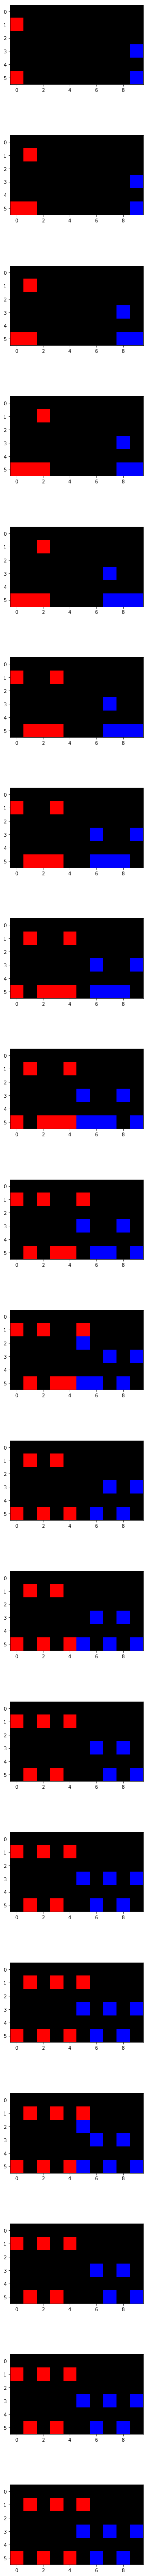

In [139]:
game_state = GameState.init_game(width=10, height=6, nb_factories=2)
game = TankWars(game_state)

# https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python
def to_image(game: TankWars):
    territory = game.get_territory()
    image = np.zeros((territory.height, territory.width, 3), 'uint8')
    image[..., 0] = player_on_map(territory, game.player_status(Player.PLAYER_1)) * 255
    image[..., 2] = player_on_map(territory, game.player_status(Player.PLAYER_2)) * 255
    return Image.fromarray(image, 'RGB')

nb_turns = 20
fig, ax = plt.subplots(figsize=(5, 5 * nb_turns), nrows=nb_turns)
frames = []

images = [to_image(game)]
for i in range(nb_turns):
    images.append(to_image(game))
    frame = ax[i].imshow(to_image(game), animated=True)
    frames.append([frame])
    game.play(diffusion_ia_play(game))

# imageio.mimsave('diffusion.gif', images)
# ani = animation.ArtistAnimation(fig, frames, interval=50, repeat_delay=1000)
plt.show()

In [ ]:
# Main problem with the diffusion algorithm is that several tanks stacked will always behave the same (unless you tank into account each tank move)... and that tank will always move !
# TODO - you can also introduce a bit of random (ponderated move by the map around the tank)